### Shelter Animal Outcomes

This competition ran from March 21 2016 to July 31 2016. We're given data collected from an animal shelter in Austin, Texas between October 1st, 2013 and March, 2016 indicated the status of an animal as it leaves the shelter. The contest description gives some background on this issue: "every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year."

Our goal is to predict the outcome of an animal, given a number of features. The following outcomes are possible:  Adoption, Died, Euthanasia, Return to owner, and Transfer.

In [1]:
import random
import datetime

import pandas as pd
import numpy as np

from plotnine import ggplot, aes, geom_histogram
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5


In [2]:
training_data = pd.read_csv('/kaggle/input/shelter-animal-outcomes/train.csv.gz')
testing_data = pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz')

training_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
...,...,...,...,...,...,...,...,...,...,...
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black


Let's take a peek at some summary statistics.

In [3]:
training_data.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A671945,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


Fortunately, the top outcome is adoption followed by transfers, and returning to their owners.

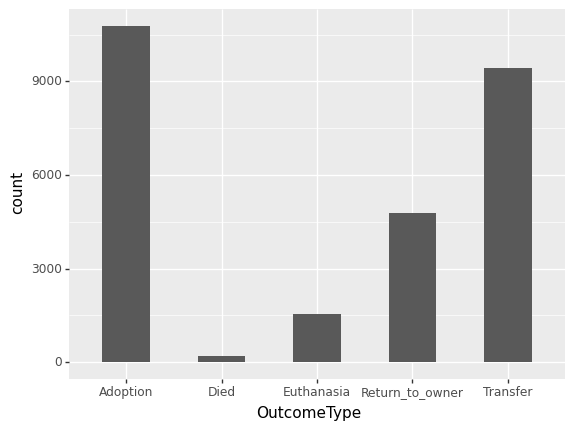

<ggplot: (8621891216270)>

In [4]:
ggplot(training_data, aes(x='OutcomeType')) + geom_histogram(binwidth=0.5)

Here we can see the top ten animal breeds in the shelter,

In [5]:
training_data.Breed.value_counts()[:10]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64

Notice that the most frequent breeds are all "mixes". Next, let's check the most common colors:

In [6]:
training_data.Color.value_counts()[:10]

Black/White          2824
Black                2292
Brown Tabby          1635
Brown Tabby/White     940
White                 931
Brown/White           884
Orange Tabby          841
Tan/White             773
Tricolor              752
Blue/White            702
Name: Color, dtype: int64

Notice the `AgeuponOutcome` feature is a string

In [7]:
training_data.AgeuponOutcome.value_counts()[:10]

1 year      3969
2 years     3742
2 months    3397
3 years     1823
1 month     1281
3 months    1277
4 years     1071
5 years      992
4 months     888
6 years      670
Name: AgeuponOutcome, dtype: int64

let's change this to a numerical value.

In [8]:
def age_outcome_to_days(x):
    if 'year' in x:
        parts = x.split()
        return int(parts[0]) * 365
    elif 'weeks' in x:
        parts = x.split()
        return int(parts[0]) * 7
    elif 'month' in x:
        parts = x.split()
        return int(parts[0]) * 30
    elif 'days' in x:
        parts = x.split()
        return int(parts[0])

### Data Preprocessing
Many of our features are strings representing categories, so we need to transform them to numerical values. We'll use `sklearn.preprocessing.LabelEncoder` to accomplish this.

In [9]:
from sklearn import preprocessing

encoder_training_data = pd.concat([training_data, testing_data])

age_upon_outcome_encoder = preprocessing.LabelEncoder()
age_upon_outcome_encoder.fit(encoder_training_data.AgeuponOutcome)

color_encoder = preprocessing.LabelEncoder()
color_encoder.fit(encoder_training_data.Color)

breed_encoder = preprocessing.LabelEncoder()
breed_encoder.fit(encoder_training_data.Breed)

animal_type_encoder = preprocessing.LabelEncoder()
animal_type_encoder.fit(encoder_training_data.AnimalType)

sex_upon_outcome_encoder = preprocessing.LabelEncoder()
sex_upon_outcome_encoder.fit(encoder_training_data.SexuponOutcome)

outcome_type_encoder = preprocessing.LabelEncoder()
outcome_type_encoder.fit(encoder_training_data.OutcomeType)

outcome_subtype_encoder = preprocessing.LabelEncoder()
outcome_subtype_encoder.fit(encoder_training_data.OutcomeSubtype)

name_encoder = preprocessing.LabelEncoder()
name_encoder.fit(encoder_training_data.Name)

LabelEncoder()

Now its time to encode the data, making it suitable for training. Additionally, we'll create a new feature `is_mix`, as well as splitting the date into year, month, and day to hopefully capture any possible date effects (maybe people adopt more around Christmas?)

In [10]:
training_data.AgeuponOutcome = age_upon_outcome_encoder.transform(training_data.AgeuponOutcome)
training_data.Color = color_encoder.transform(training_data.Color)
training_data['is_mix'] = training_data.Breed.apply(lambda x: 1 if 'Mix' in x else 0)
training_data.Breed = breed_encoder.transform(training_data.Breed)
training_data.AnimalType = animal_type_encoder.transform(training_data.AnimalType)
training_data.SexuponOutcome = sex_upon_outcome_encoder.transform(training_data.SexuponOutcome)
training_data.OutcomeType = outcome_type_encoder.transform(training_data.OutcomeType)
training_data.OutcomeSubtype = outcome_subtype_encoder.transform(training_data.OutcomeSubtype)
training_data.Name = name_encoder.transform(training_data.Name)
training_data['year'] = training_data.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
training_data['month'] = training_data.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
training_data['day'] = training_data.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day)

training_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,is_mix,year,month,day
0,A671945,2910,2014-02-12 18:22:00,3,16,1,2,5,1482,146,1,2014,2,12
1,A656520,2265,2013-10-13 12:44:00,2,15,0,3,5,775,184,1,2013,10,13
2,A686464,5500,2015-01-31 12:28:00,0,6,1,2,21,1293,97,1,2015,1,31
3,A683430,7968,2014-07-11 19:09:00,4,12,0,1,26,775,47,1,2014,7,11
4,A667013,7968,2013-11-15 12:52:00,4,12,1,2,21,1101,311,0,2013,11,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,A702446,7968,2015-05-14 11:56:00,4,12,0,1,2,775,125,1,2015,5,14
26725,A718934,7968,2016-01-20 18:59:00,4,14,0,3,25,775,117,1,2016,1,20
26726,A698128,7916,2015-03-09 13:33:00,0,16,1,2,31,1239,396,1,2015,3,9
26727,A677478,7968,2014-04-27 12:22:00,4,12,0,1,30,775,6,1,2014,4,27


In [11]:
X = training_data.drop(['DateTime', 'OutcomeType', 'OutcomeSubtype', 'AnimalID'], axis=1)
y = training_data.OutcomeType

In [12]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.5992740557359619

Now let's try a couple of different models so that we have something to this result compare to.

In [13]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.5953086209774703

In [14]:
clf =  DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.5413970491737875

In [15]:
clf = GradientBoostingClassifier(n_estimators=10)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.607766883399354

It appears that a gradient boosted classifier performs best on the training set. Let's use that classifier but increase the number of estimators.

In [16]:
clf = GradientBoostingClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.6412136750521533

In [17]:
clf.fit(X, y)
clf.feature_importances_

array([0.10626813, 0.09781817, 0.54476138, 0.19971507, 0.02643113,
       0.00675372, 0.00129998, 0.00237428, 0.00778559, 0.00679255])

The most important features are `SexuponOutcome` and `AnimalType`.

It's time to prepare the testing data and make our predictions.

In [18]:
testing_data = pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz')
testing_data.AgeuponOutcome = age_upon_outcome_encoder.transform(testing_data.AgeuponOutcome)
testing_data.Color = color_encoder.transform(testing_data.Color)
testing_data['is_mix'] = testing_data.Breed.apply(lambda x: 1 if 'Mix' in x else 0)
testing_data.Breed = breed_encoder.transform(testing_data.Breed)
testing_data.AnimalType = animal_type_encoder.transform(testing_data.AnimalType)
testing_data.SexuponOutcome = sex_upon_outcome_encoder.transform(testing_data.SexuponOutcome)
testing_data.Name = name_encoder.transform(testing_data.Name)
testing_data['year'] = testing_data.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
testing_data['month'] = testing_data.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
testing_data['day'] = testing_data.DateTime.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day)

testing_data

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,is_mix,year,month,day
0,1,6995,2015-10-12 12:15:00,1,0,6,1023,283,1,2015,10,12
1,2,1368,2014-07-26 17:59:00,1,3,21,875,40,0,2014,7,26
2,3,2871,2016-01-13 12:20:00,0,2,5,775,117,1,2016,1,13
3,4,5728,2013-12-28 18:12:00,1,1,29,658,346,1,2013,12,28
4,5,6679,2015-09-24 17:59:00,1,2,21,1165,359,1,2015,9,24
...,...,...,...,...,...,...,...,...,...,...,...,...
11451,11452,7968,2014-07-08 14:50:00,0,2,19,775,6,1,2014,7,8
11452,11453,7968,2014-10-21 12:57:00,0,0,20,775,46,1,2014,10,21
11453,11454,7968,2014-09-29 09:00:00,0,0,5,775,156,1,2014,9,29
11454,11455,5964,2015-09-05 17:16:00,1,2,38,841,40,1,2015,9,5


In [19]:
test_X = testing_data.drop(['ID', 'DateTime'], axis=1)
test_y_hat = clf.predict_proba(test_X)
M = []
id = 1
for i in range(len(test_y_hat)):
    elt = {'ID': id}
    id += 1
    for j in range(5):
        key = outcome_type_encoder.inverse_transform([j])[0]
        elt[key] = test_y_hat[i][j]
    M.append(elt)
submission = pd.DataFrame(M)
submission

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.068928,0.005728,0.032291,0.323091,0.569962
1,2,0.542297,0.001025,0.023842,0.293583,0.139254
2,3,0.598291,0.003399,0.016394,0.091643,0.290273
3,4,0.094115,0.007260,0.071078,0.318637,0.508910
4,5,0.465852,0.001134,0.020523,0.344624,0.167868
...,...,...,...,...,...,...
11451,11452,0.837141,0.003156,0.017715,0.012371,0.129616
11452,11453,0.004167,0.014805,0.042421,0.012309,0.926298
11453,11454,0.008563,0.013868,0.117938,0.010053,0.849577
11454,11455,0.378625,0.001469,0.024585,0.442339,0.152982


In [20]:
submission.to_csv("submission.csv", index=False)